In [1]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff

import time
import tracemalloc

In [2]:
W,H = (150,150)
o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2)#.cuda()
disp_range = 0.25#0.25
disp_hw = 5
displace_range = 11

grid_size = 32#25#30
#grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features
    
    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [3]:
model = OBELISK2d(16)
model.load_state_dict(torch.load("models/Experiment_1/obel16_oneFixed_25_11_21-12-10.pth"))

<All keys matched successfully>

In [4]:
path = '/share/data_ultraschall/nicke_ma/data'

frames = torch.load(os.path.join(path,'test_frames_disp_6.pth'))
segs = torch.load(os.path.join(path,'test_segs_disp_6.pth')) * 2

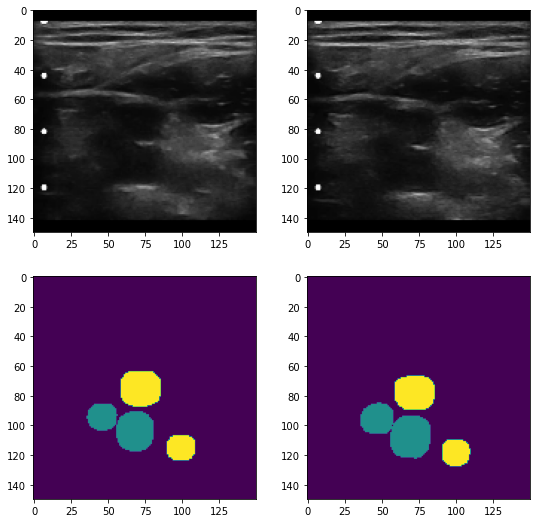

In [10]:
idx = 49

fig, ax = plt.subplots(2,2, figsize=(9,9))

ax[0][0].imshow(frames[idx][0],cmap='gray')
ax[0][1].imshow(frames[idx][1],cmap='gray')

ax[1][0].imshow(segs[idx][0])
ax[1][1].imshow(segs[idx][1])

In [17]:
fixed = frames[idx][0].float()
moving = frames[idx][1].float()

feat1 = model(fixed.unsqueeze(0).unsqueeze(0))
feat2 = model(moving.unsqueeze(0).unsqueeze(0))
ssd_distance = correlation_layer(displace_range, feat2, feat1)
soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
# scaling
flow=F.interpolate(disp_xy,size=(150,150), mode='bicubic')
rgb = showFlow(flow.detach().cpu().transpose(-2,-1))

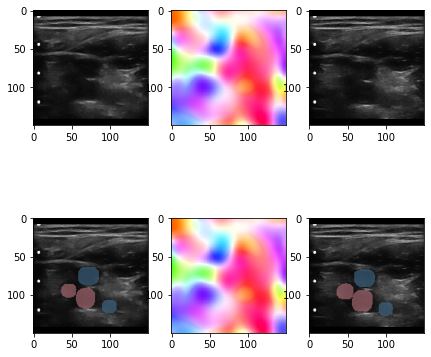

In [23]:
idx = 49
fig, ax = plt.subplots(2,3, figsize=(7,7))

ax[0][0].imshow(frames[idx][0],cmap='gray')
ax[0][1].imshow(rgb)
ax[0][2].imshow(frames[idx][1],cmap='gray')
ax[1][0].imshow(overlaySegment(frames[idx][0], segs[idx][0]))
ax[1][1].imshow(rgb)
ax[1][2].imshow(overlaySegment(frames[idx][1], segs[idx][1]))